<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Quantifying river channel evolution with Landlab
These exercises are based on a project orginally designed by Kelin Whipple at Arizona State University. 

<hr>
<small> For instructions on how to run an interactive IPython notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For tutorials on learning Landlab, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

** What is this notebook? **

This notebook illustrates the evolution of detachment-limited channels in an actively uplifting landscape. The landscape evolves according to the equation:

\begin{equation}
 \frac{d z}{d t} = -K_\text{sp} A^{m_{sp}} S^{n_{sp}} + U
\end{equation}
Here, $K_{sp}$ is the coefficient on fluvial incision, and $m_{sp}$ and $n_{sp}$ are positive exponents, usually thought to have a ratio, $m_{sp}/n_{sp} \approx 0.5$. $A$ is drainage area and $S$ is the slope of steepest descent ($-\frac{dz}{dx}$) where $x$ is horizontal distance (positive in the downslope direction) and $z$ is elevation. (If slope is negative there is no fluvial erosion.) $U$ is an externally-applied rock uplift field.

The fluvial erosion term is also known as the stream power equation. Before using this notebook you should be familiar with this equation from class lectures and reading.

** What will you do? **

In this exercise you will modify the code to get a better understanding of how rock uplift and erodibility control fluvial channel form.

Start at the top by reading each block of text and sequentially running each code block (shift - enter OR got to the _Cell_ pulldown menu at the top and choose _Run Cells_). 

If you just change one code block and rerun only that code block, only the parts of the code in that code block will be updated. (E.g. if you change parameters but don't reset the code blocks that initialize run time or topography, then these values will not be reset.) 

** Questions to answer before starting this assignment. **

Answer these questions before running the notebook.

1. What do you think will happen to total relief (defined as the maximum minus the minimum elevation) and channel slope at steady state if $K_{sp}$ is uniformly increased?
2. What do you think will happen to total relief and channel slope at steady state if $U$ is uniformly increased?
3. How do you think a steady-state landscape with a uniform low rock uplift rate will respond if rock uplift is uniformly increased? How will channel slopes change through time?

** Now on to the code... **

First we have to import the parts of Python and Landlab that are needed to run this code. You should not have to change this first code block.

In [1]:
# Code block 1

import numpy as np
from landlab import RasterModelGrid
from landlab.components import StreamPowerEroder, FlowRouter
from landlab.components import ChiFinder, SteepnessFinder
from landlab.plot import channel_profile as prf
from landlab import imshow_grid
from matplotlib import pyplot as plt
from landlab.io import write_esri_ascii
#below is to make plots show up in the notebook
%matplotlib inline 

Make a grid and set boundary conditions. 

In [2]:
# Code Block 2

number_of_rows = 50 # number of raster cells in vertical direction (y)
number_of_columns = 100 # number of raster cells in horizontal direction (x)
dxy  = 200 # side length of a raster model cell, or resolution [m]

# Below is a raster (square cells) grid, with equal width and height 
mg = RasterModelGrid((number_of_rows,number_of_columns), dxy)

# Set boundary conditions - only the south side of the grid is open.
# Boolean parameters are sent to function in order of
# east, north, west, south.
mg.set_closed_boundaries_at_grid_edges(True, True, True, False)

Here we make the initial grid of elevation of zeros with a very small amount of noise to make a more pleasing network.

In [3]:
# Code Block 3

np.random.seed(35) # seed set to zero so our figures are reproducible
mg_noise = np.random.rand(mg.number_of_nodes)/1000. # intial noise on elevation gri

# set up the elevation on the grid
zr = mg.add_zeros('node', 'topographic__elevation')
zr += mg_noise

Set parameters related to time.

In [14]:
# Code Block 4

tmax = 1E5  # time for the model to run [yr] (Original value was 5E5 yr)
dt = 500 # time step [yr] (Original value was 5000 yr)
total_time = 0 # amount of time the landscape has evolved [yr]
# total_time will increase as you keep running the code.

t = np.arange(0, tmax, dt) # each of the time steps that the code will run

Set parameters for incision and intializing all of the process components that do the work. We also initialize tools for quantifying the landscape.

In [5]:
# Code Block 5

# Original K_sp value is 1e-5
K_sp = 1.E-5  # units vary depending on m_sp and n_sp 
m_sp = 0.5 # exponent on drainage area in stream power equation
n_sp = 1.0 # exponent on slope in stream power equation

frr = FlowRouter(mg) # intializing flow routing
spr = StreamPowerEroder(mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0,
                        use_Q=None) #initializing stream power incision

theta = m_sp/n_sp 
# initialize the component that will calculate channel steepness
sf = SteepnessFinder(mg, reference_concavity=theta, min_drainage_area=1000.)
# initialize the component that will calculate the chi index
cf = ChiFinder(mg, min_drainage_area=1000., reference_concavity=theta, use_true_dx=True)

Initialize rock uplift rate. This will need to be changed later.

In [15]:
# Code Block 6

#  uplift_rate [m/yr] (Original value is 0.0001 m/yr)
uplift_rate = np.ones(mg.number_of_nodes)*0.0001 

## If you want to add a one-time event that uplifts only part of the 
## landscape, uncomment the 3 lines below
#fault_location = 4000  # [m]
#uplift_amount = 10 # [m]
#zr[np.where(mg.node_y>fault_location)] += uplift_amount 

## IMPORTANT! To use the below fault generator, comment the one-time 
## uplift event above if it isn't already commented out.
## Code below creates a fault horizontally across the grid.
## Uplift rates are greater where y values  > fault location.
## To use, uncomment the 5 code lines below and edit to your values
fault_location = 4000  # [m]
low_uplift_rate = 0.0001 # [m/yr]
high_uplift_rate = 0.0004 # [m/yr]
uplift_rate[np.where(mg.node_y<fault_location)] = low_uplift_rate
uplift_rate[np.where(mg.node_y>fault_location)] = high_uplift_rate

## IMPORTANT! To use below rock uplift gradient, comment the two
## uplift options above if they aren't already commented out.
## If you want a linear gradient in uplift rate 
## (increasing uplift into the range),
## uncomment the 4 code lines below and edit to your values.
#low_uplift_rate = 0.0001 # [m/yr]
#high_uplift_rate = 0.004 # [m/yr]
## below is uplift gradient per node row index, NOT row value in meters
#uplift_rate_gradient = (high_uplift_rate - low_uplift_rate)/(number_of_rows-3)
#uplift_rate = low_uplift_rate + ((mg.node_y / dxy)-1) * uplift_rate_gradient

Now for the code loop. 

Note that you can rerun Code Block 7 many times, and as long as you don't reset the elevation field (Code Block 3), it will take the already evolved landscape and evolve it even more. If you want to change parameters in other code blocks (e.g. Code Block 5 or 6), you can do that too, and as long as you don't reset the elevation field (Code Block 3) the new parameters will apply on the already evolved topography. 

In [20]:
# Code Block 7

for ti in t:
    zr[mg.core_nodes] += uplift_rate[mg.core_nodes]*dt # uplift the landscape
    frr.run_one_step() # route flow
    spr.run_one_step(dt) # fluvial incision
    total_time += dt # update time keeper
    print(total_time)

100500
101000
101500
102000
102500
103000
103500
104000
104500
105000
105500
106000
106500
107000
107500
108000
108500
109000
109500
110000
110500
111000
111500
112000
112500
113000
113500
114000
114500
115000
115500
116000
116500
117000
117500
118000
118500
119000
119500
120000
120500
121000
121500
122000
122500
123000
123500
124000
124500
125000
125500
126000
126500
127000
127500
128000
128500
129000
129500
130000
130500
131000
131500
132000
132500
133000
133500
134000
134500
135000
135500
136000
136500
137000
137500
138000
138500
139000
139500
140000
140500
141000
141500
142000
142500
143000
143500
144000
144500
145000
145500
146000
146500
147000
147500
148000
148500
149000
149500
150000
150500
151000
151500
152000
152500
153000
153500
154000
154500
155000
155500
156000
156500
157000
157500
158000
158500
159000
159500
160000
160500
161000
161500
162000
162500
163000
163500
164000
164500
165000
165500
166000
166500
167000
167500
168000
168500
169000
169500
170000
170500
171000
171500

Plot the topography.

('Maximum elevation is ', 76.444454227675251)


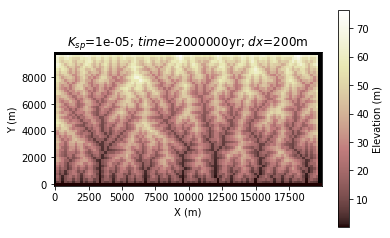

In [8]:
# Code Block 8

imshow_grid(mg, 'topographic__elevation', grid_units=('m', 'm'),
                var_name='Elevation (m)')
title_text = '$K_{sp}$='+str(K_sp) + '; $time$='+str(total_time) + 'yr; $dx$='+str(dxy) + 'm'
plt.title(title_text)

max_elev = np.max(zr)
print('Maximum elevation is ', np.max(zr))

Plot the slope and area data at each point on the landscape (in log-log space).

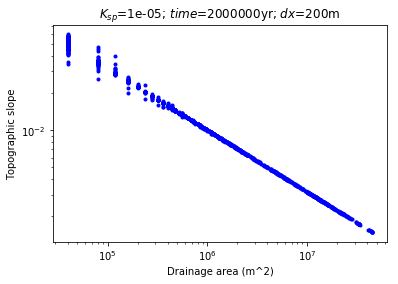

In [9]:
# Code Block 9

indices = np.where(mg.status_at_node[mg.at_node['flow__receiver_node']] == 0)
plt.loglog(mg.at_node['drainage_area'][indices],
           mg.at_node['topographic__steepest_slope'][indices], 'b.')
plt.ylabel('Topographic slope')
plt.xlabel('Drainage area (m^2)')
title_text = '$K_{sp}$='+str(K_sp) + '; $time$='+str(total_time) + 'yr; $dx$='+str(dxy) + 'm'
plt.title(title_text)

It is slightly easier to interpret slope-area data when we look at a single channel, rather than the entire landscape. Below we plot the profile and slope-area data for the three largest channels on the landscape.

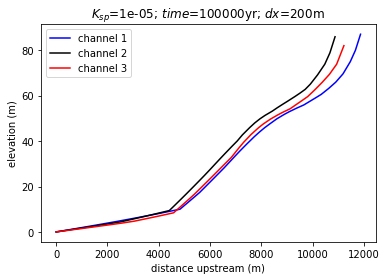

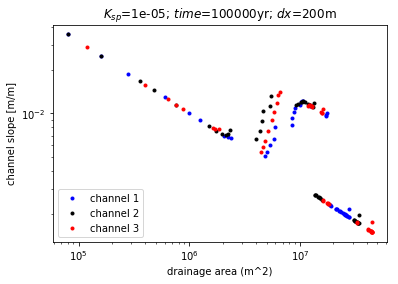

In [17]:
# Code Block 10

# find the location of the largest channels, set initially to find 3 chans
profile_IDs = prf.channel_nodes(mg, mg.at_node['topographic__steepest_slope'],
                                mg.at_node['drainage_area'],
                                mg.at_node['flow__receiver_node'],
                                number_of_channels=3)

# find the upstream distances in these channels
dists_upstr = prf.get_distances_upstream(
    mg, len(mg.at_node['topographic__steepest_slope']),
    profile_IDs, mg.at_node['flow__link_to_receiver_node'])

# channel profiles
plt.figure(1)
plt.plot(dists_upstr[0], zr[profile_IDs[0]], 'b-', label='channel 1')
plt.plot(dists_upstr[1], zr[profile_IDs[1]], 'k-', label='channel 2')
plt.plot(dists_upstr[2], zr[profile_IDs[2]], 'r-', label='channel 3')
plt.xlabel('distance upstream (m)')
plt.ylabel('elevation (m)')
plt.legend(loc='upper left')
title_text = '$K_{sp}$='+str(K_sp) + '; $time$='+str(total_time) + 'yr; $dx$='+str(dxy) + 'm'
plt.title(title_text)

# slope-area data in just the profiled channels
plt.figure(2)
plt.loglog(mg.at_node['drainage_area'][profile_IDs[0]],
           mg.at_node['topographic__steepest_slope'][profile_IDs[0]], 'b.',
           label='channel 1')
plt.loglog(mg.at_node['drainage_area'][profile_IDs[1]],
           mg.at_node['topographic__steepest_slope'][profile_IDs[1]], 'k.',
           label='channel 2')
plt.loglog(mg.at_node['drainage_area'][profile_IDs[2]],
           mg.at_node['topographic__steepest_slope'][profile_IDs[2]], 'r.',
           label='channel 3')
plt.legend(loc='lower left')
plt.xlabel('drainage area (m^2)')
plt.ylabel('channel slope [m/m]')
title_text = '$K_{sp}$='+str(K_sp) + '; $time$='+str(total_time) + 'yr; $dx$='+str(dxy) + 'm'
plt.title(title_text)

The chi index is a useful way to quantitatively interpret fluvial channels. Below we plot the chi index in the three largest channels and also a chi map across the entire landscape. 

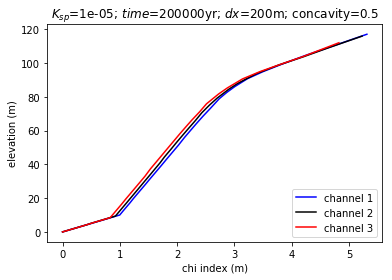

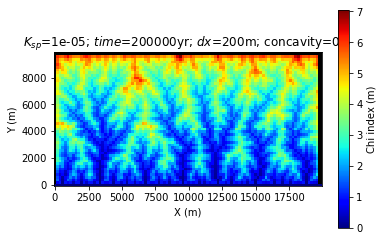

In [21]:
# Code Block 11

# Relocate profile IDs and calculate distance upstream, just in case
# Code Blocks are run out-of-order
profile_IDs = prf.channel_nodes(mg, mg.at_node['topographic__steepest_slope'],
                                mg.at_node['drainage_area'],
                                mg.at_node['flow__receiver_node'],
                                number_of_channels=3)

dists_upstr = prf.get_distances_upstream(
    mg, len(mg.at_node['topographic__steepest_slope']),
    profile_IDs, mg.at_node['flow__link_to_receiver_node'])

# calculate the chi index
cf.calculate_chi()

# chi-elevation plots in the profiled channels
plt.figure(3)
plt.plot(mg.at_node['channel__chi_index'][profile_IDs[0]], 
         mg.at_node['topographic__elevation'][profile_IDs[0]],'b-',
         label='channel 1')
plt.plot(mg.at_node['channel__chi_index'][profile_IDs[1]], 
         mg.at_node['topographic__elevation'][profile_IDs[1]],'k-',
         label='channel 2')
plt.plot(mg.at_node['channel__chi_index'][profile_IDs[2]], 
         mg.at_node['topographic__elevation'][profile_IDs[2]],'r-',
         label='channel 3')
plt.xlabel('chi index (m)')
plt.ylabel('elevation (m)')
plt.legend(loc = 'lower right')
title_text = '$K_{sp}$='+str(K_sp) + '; $time$='+str(total_time) + \
            'yr; $dx$='+str(dxy) + 'm' + '; concavity='+str(theta)
plt.title(title_text)

# chi map
plt.figure(4)
imshow_grid(mg, 'channel__chi_index', grid_units=('m', 'm'),
                var_name='Chi index (m)', cmap='jet')
title_text = '$K_{sp}$='+str(K_sp) + '; $time$='+str(total_time) + \
            'yr; $dx$='+str(dxy) + 'm' + '; concavity='+str(theta)
plt.title(title_text)

The channel steepness index is another useful index to quantify fluvial channels. Below we plot the steepness index in the same three largest channels, and also plot steepness index across the grid.

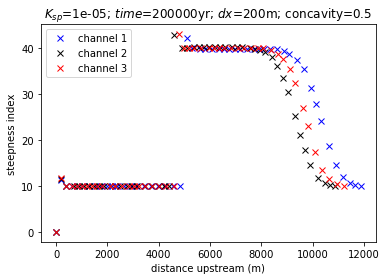

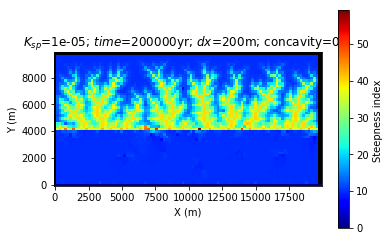

In [22]:
# Code Block 12

# Relocate profile IDs and calculate distance upstream, just in case
# Code Blocks are run out-of-order
profile_IDs = prf.channel_nodes(mg, mg.at_node['topographic__steepest_slope'],
                                mg.at_node['drainage_area'],
                                mg.at_node['flow__receiver_node'],
                                number_of_channels=3)

dists_upstr = prf.get_distances_upstream(
    mg, len(mg.at_node['topographic__steepest_slope']),
    profile_IDs, mg.at_node['flow__link_to_receiver_node'])

# calculate channel steepness
sf.calculate_steepnesses()

# plots of steepnes vs. distance upstream in the profiled channels
plt.figure(5)
plt.plot(dists_upstr[0], mg.at_node['channel__steepness_index'][profile_IDs[0]], 'bx',
         label='channel 1')
plt.plot(dists_upstr[1], mg.at_node['channel__steepness_index'][profile_IDs[1]], 'kx',
         label='channel 2')
plt.plot(dists_upstr[2], mg.at_node['channel__steepness_index'][profile_IDs[2]], 'rx',
         label='channel 3')
plt.xlabel('distance upstream (m)')
plt.ylabel('steepness index')
plt.legend(loc = 'upper left')
title_text = '$K_{sp}$='+str(K_sp) + '; $time$='+str(total_time) + \
            'yr; $dx$='+str(dxy) + 'm' + '; concavity='+str(theta)
plt.title(title_text)

# channel steepness map
plt.figure(6)
imshow_grid(mg, 'channel__steepness_index', grid_units=('m', 'm'),
                var_name='Steepness index ', cmap='jet')
title_text = '$K_{sp}$='+str(K_sp) + '; $time$='+str(total_time) + \
            'yr; $dx$='+str(dxy) + 'm' + '; concavity='+str(theta)
plt.title(title_text)

If you have a grid that you want to export, uncomment and edit the appropriate lines below and run the code block.

In [13]:
# Code Block 13

## Below has the name of the file that data will be written to.
## You need to change the name of the file every time that you want
## to write data, otherwise you will get an error.
## This will write to the directory that you are running the code in.
#write_file_name = 'data_file.txt'
## Below is writing elevation data in the ESRI ascii format so that it can
## easily be read into Arc GIS or back into Landlab.
#write_esri_ascii(write_file_name, mg, 'topographic__elevation')

After running every code block once, has the landscape reached steady state? Answer: NO! How do you know? After you think about this, you are ready to complete this project.


Answer the following questions using the code above. All answers should be typed, and supporting figures (produced using the code) should be embedded in one document that you hand in. Code Blocks 8-12 produce different figures that you may find useful. You can use any or all of these different figures to help you with the questions below. (Download or screenshoot the figures.) 

Anything with a question mark should be answered in the document that you hand in. Make sure your write in full sentences and proofread the document that you hand in.

1. **Steady state with low uplift rate. ** Using the parameters provided in the initial notebook, run the landscape to steady state. (Note that you can keep running the main evolution loop - Code Block 7 - and the different plotting blocks without running the code blocks above them.) How did you know that the landscape reached steady state? Note the approximate time that it took to reach steady state for your own reference. (This will be usefull for later questions.) Include appropriate plots. (If you want to analyze these landscapes outside of Landlab or save for later, make sure you save the elevation data to a text file (Code Block 13).)

2. **Transient landscape responding to an increase in rock uplift. ** Use the steady-state landscape that you generated in the first question, and increase rock uplift uniformly by a factor of 4 (Code Block 6). Before running this, make sure that you also reduce _tmax_ to 1e5 yrs and _dt_ to 500 yrs (Code Block 4). Run this until the maximum elevation in the grid is ~ 170 m and observe how the landscape gets to this elevation. What patterns do you see in the supporting plots that illustrate this type of transient? Which patterns, if any, are diagnostic of a landscape response to uniform increase in rock uplift rate? (You may need to answer this after completing all of the questions.)

3. ** Steady-state landscape with increased rock uplift. ** Now run the landscape from question 2 until it reaches steady state. (You can increase _tmax_ and _dt_ to make this run faster.) Provide a plot that illustrates that the landscape is in steady state. What aspects of the landscape have changed in comparison with the initial steady state landscape from question 1?

4. ** Increase erodibility. ** Use the steady-state landscape from question 3, and now double erodibility ($K_{sp}$ = 2E-5, Code Block 5). Set tmax to 1e5 yrs (Code Block 4). Run for 1e5 yrs and save the plots that you think are diagnostic. Run for another 1e5 yrs and save plots again. Now run for 5e5 yrs and save plots of the topography and slope-area relationship. Quantitatively describe how the landscape evolves in response to the increase in erodibility and provide supporting plots. What could cause a uniform increase in erodibility?

5. ** Spatially varible uplift - discrete, massive earthquake. ** (First recreate the steady-state landscape with low uplift rate (uniform at 1e-4 m/yr) and low erodbility ($K_{sp}$ = 1E-5, i.e. setting in question 1. You can set _tmax_ to the time to steady state and _dt_ to 5000 yrs.) Now add a seismic event to this steady state landscape - a fault that runs horizontally across the landscape at y = 4000 m, and instantaneously uplifts half the landscape by 10 meters (Code Block 6). In this case, we will keep background uplift uniform. Set _tmax_ to 1e5 yrs and _dt_ to 500 yrs (Code Block 4) before evolving the landscape after the fault. Now run the time loop four times and look at the different plots after each loop. How does the landscape respond to this fault? What patterns do you see in the supporting plots that illustrate this type of transient? Which patterns, if any, are diagnostic of a channel response to an earthquake? (You may need to answer this after completing all of the questions.)

6. ** Spatially Varible Rock Uplift - discrete fault with two different uplift rates. ** (First recreate the steady-state landscape with low uplift rate (uniform at 1e-4 m/yr) and low erodbility ($K_{sp}$ = 1E-5, i.e. setting in question 1. You can set _tmax_ to the time to steady state and _dt_ to 5000 yrs.) Now we will add a fault (at y = 4000 m) to this landscape. In this case the uplift rate on the footwall is higher (0.0004 m/yr) than on the hanging wall (uplift rate = 0.0001 m/yr). (Edit Code Block 6.) Set tmax to 1e5 yrs (Code Block 4) and _dt_ to 500 yrs before you start running the time loop for the fault. Now run the time loop four separate times and look at the different plots after each loop. How does the landscape respond to this fault? What patterns do you see in the supporting plots that illustrate this type of transient? Which patterns, if any, are diagnostic of a channel response to a this type of gradient in rock uplift rates? (You may need to answer this after completing all of the questions.)

7. ** Spatially Varible Rock Uplift - gradient in uplift across the range. ** (First recreate the steady-state landscape with low uplift rate (uniform at 1e-4 m/yr) and low erodbility ($K_{sp}$ = 1E-5, i.e. setting in question 1. You can set _tmax_ to the time to steady state and _dt_ to 5000 yrs.) Now we will add a linear gradient in uplift rate across the entire range (edit Code Block 6). The maximum uplift rate will be 0.0004 m/yr at the core of the range, and 0.0001 m/yr at the front of the range. Set tmax to 1e5 yrs (Code Block 4) and _dt_ to 500 yrs before you start running the time loop for the fault before you start running the time loop with the rock uplift gradient. Now run the time loop four separate times and look at the different plots after each loop. How does the landscape respond to this gradient in uplift rate? What patterns do you see in the supporting plots that illustrate this type of transient? Which patterns, if any, are diagnostic of a channel response to this type of gradient in rock uplift rates? (You may need to answer this after completing all of the questions.)

8. ** Final Reflection. ** Was your initial insight into how parameters would affect the landscape correct? Discuss in 6 sentences or less.